In [100]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [101]:
## load files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [102]:
print ('The train data has {} images.'.format(train.shape[0]))
print ('The test data has {} images.'.format(test.shape[0]))

The train data has 5983 images.
The test data has 3219 images.


In [103]:
# unique label count
print ('The train data has {} unique labels'.format(train['Class'].nunique()))

The train data has 4 unique labels


In [104]:
train["Class"].unique()

array(['Food', 'misc', 'Attire', 'Decorationandsignage'], dtype=object)

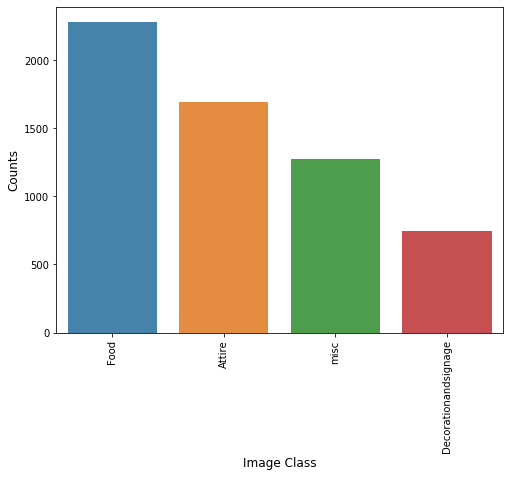

In [105]:

label_counts = train.Class.value_counts()
plt.figure(figsize = (8,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Class', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [106]:
TRAIN_PATH = 'Train Images/'
TEST_PATH = 'Test Images/'

In [107]:
def read_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64)) # you can resize to  (128,128) or (256,256)
    return img

In [108]:
train_data = []
test_data = []
train_labels = train['Class'].values

for img_name in tqdm(train['Image'].values):
    train_data.append(read_image(TRAIN_PATH + img_name))
    
for img in tqdm(test['Image'].values):
    test_data.append(read_image(TRAIN_PATH + img_name))

100%|████████████████████████████████████████████████████████████████████████████| 3219/3219 [00:01<00:00, 2202.59it/s]


In [109]:
# normalize the images
x_train = np.array(train_data, np.float32) / 255.
x_test = np.array(test_data, np.float32) / 255.

In [110]:
# target variable - encoding numeric value
label_list = train['Class'].tolist()
Y_train = {k:v+1 for v,k in enumerate(set(label_list))}
y_train = [Y_train[k] for k in label_list]     

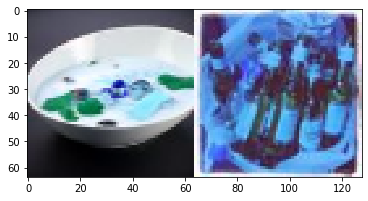

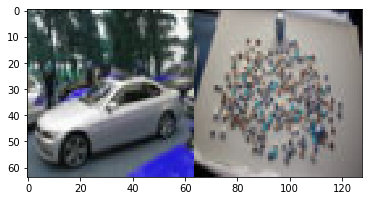

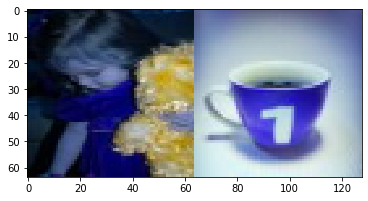

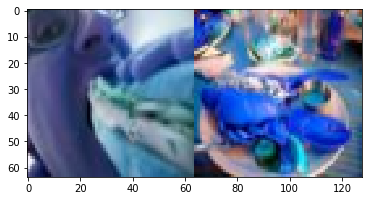

In [111]:
# check some images
def show_images(ix):
    image_train = read_image(TRAIN_PATH + train.Image[ix] )
    image_test = read_image(TEST_PATH + test.Image[ix] )
    
    pair = np.concatenate((image_train, image_test), axis=1)
    
    plt.figure(figsize = (6,6))
    plt.imshow(pair)
    
# first 4 images in train and test set
for idx in range(4):
    show_images(idx)

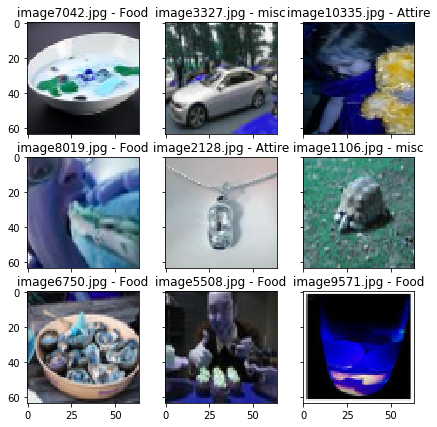

In [112]:
## just images doesn't help, lets see the images with their respective labels
plt.rc('axes', grid=False)

_, axs = plt.subplots(3,3, sharex = 'col', sharey='row', figsize = (7,7))
axs = axs.ravel()

# lets see first 8 images - you can increase i value to see more images
for i, (image_name, label) in enumerate(zip(train.Image, train.Class)):
    if i <= 8:
        img = read_image(TRAIN_PATH + image_name)
        axs[i].imshow(img)
        axs[i].set_title('{} - {}'.format(image_name, label))
    else:
        break

In [113]:
# lets train our  model, we'll use keras.
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [114]:
## keras accepts target variable as a ndarray so that we can set one output neuron per class
y_train = to_categorical(y_train)

In [115]:
## neural net architechture

model = Sequential()
model.add(Convolution2D(32, (3,3), activation='relu', padding='same',input_shape = (64,64,3))) # if you resize the image above, shape would be (128,128,3)
model.add(Convolution2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(y_train.shape[1], activation='softmax'))


In [116]:
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)

train_datagen.fit(x_train)

In [117]:
#model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [118]:
early_stops = EarlyStopping(patience=3, monitor='val_acc')

In [119]:
history = model.fit(x_train, y_train, batch_size = 10, epochs = 40, validation_split = 0.2, callbacks=[early_stops])

Train on 4786 samples, validate on 1197 samples
Epoch 1/40
4786/4786 [==============================] - 9s 2ms/step - loss: 1.5424 - accuracy: 0.3142 - val_loss: 1.4440 - val_accuracy: 0.4002
Epoch 2/40
 100/4786 [..............................] - ETA: 8s - loss: 1.4371 - accuracy: 0.3100

C:\Users\harka\Miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


4786/4786 [==============================] - 9s 2ms/step - loss: 1.3688 - accuracy: 0.3606 - val_loss: 1.3208 - val_accuracy: 0.4002
Epoch 3/40
4786/4786 [==============================] - 9s 2ms/step - loss: 1.3461 - accuracy: 0.3588 - val_loss: 1.3140 - val_accuracy: 0.4002
Epoch 4/40
4786/4786 [==============================] - 9s 2ms/step - loss: 1.3386 - accuracy: 0.3569 - val_loss: 1.3086 - val_accuracy: 0.4002
Epoch 5/40
4786/4786 [==============================] - 9s 2ms/step - loss: 1.3369 - accuracy: 0.3625 - val_loss: 1.3086 - val_accuracy: 0.4002
Epoch 6/40
4786/4786 [==============================] - 9s 2ms/step - loss: 1.3307 - accuracy: 0.3615 - val_loss: 1.2987 - val_accuracy: 0.4002
Epoch 7/40
4786/4786 [==============================] - 9s 2ms/step - loss: 1.3289 - accuracy: 0.3604 - val_loss: 1.3026 - val_accuracy: 0.4010
Epoch 8/40
4786/4786 [==============================] - 10s 2ms/step - loss: 1.3277 - accuracy: 0.3652 - val_loss: 1.2930 - val_accuracy: 0.4002
Ep

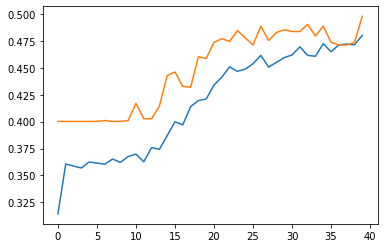

In [120]:
# list all data in history
from matplotlib import pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

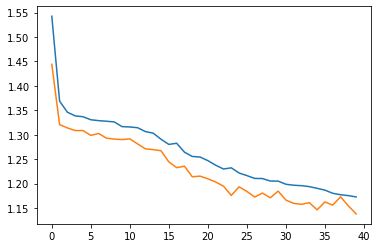

In [121]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [122]:
# make prediction
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis= 1)

In [123]:
# get predicted labels
y_maps = dict()
y_maps = {v:k for k, v in Y_train.items()}
pred_labels = [y_maps[k] for k in predictions]

In [124]:
# make submission
sub1 = pd.DataFrame({'Image':test.Image, 'Class':pred_labels})
sub1.to_csv('sub_one.csv', index=False)